This notebook elaborates on
[this YouTube video clip](https://www.youtube.com/watch?v=OMDn66kM9Qc
),
where Alfredo Canziani introduced the audience to PyTorch (before the transition to PyTorch Lightning).

## Packages and Their Configurations

In [1]:
!pip list | grep torch

torch                            2.1.0+cu118
torchaudio                       2.1.0+cu118
torchdata                        0.7.0
torchsummary                     1.5.1
torchtext                        0.16.0
torchvision                      0.16.0+cu118


In [2]:
# !pip install -qqq ipdb

In [3]:
# import ipdb
import pdb
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

In [4]:
plt.style.use("dark_background")

## Model

In [27]:
# device = torch.device("cpu")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [28]:
def instantiate_our_simple_model(*, num_intermediate_neurons=64, dropout_proba=0.0):
    """
    A simple multi-layer perceptron model
    """
    return nn.Sequential(
        nn.Linear(28*28, num_intermediate_neurons),
        nn.ReLU(),
        nn.Linear(num_intermediate_neurons, num_intermediate_neurons),
        nn.ReLU(),
        nn.Dropout(dropout_proba),
        nn.Linear(num_intermediate_neurons, 10),
    )

In [29]:
class ResNet(nn.Module):
    def __init__(self, *, num_intermediate_neurons=64, dropout_proba=0.0):
        super().__init__()
        self.h1 = nn.Linear(28*28, num_intermediate_neurons)
        self.h2 = nn.Linear(num_intermediate_neurons, num_intermediate_neurons)
        self.h3 = nn.Linear(num_intermediate_neurons, 10)
        self.dropout = nn.Dropout(dropout_proba)

    def forward(self, x):
        h1 = self.h1(x)
        a1 = F.relu(h1)
        h2 = self.h2(a1)
        a2 = F.relu(h2)
        d2 = self.dropout(a1 + a2)
        logits = self.h3(d2)
        return logits

Try to play with the following **diff choices** of models.

In [30]:
# model = instantiate_our_simple_model()

# A large enough model to notice the diff btw GPU and CPU training
#model = instantiate_our_simple_model(num_intermediate_neurons=5_000)
#model = instantiate_our_simple_model(num_intermediate_neurons=5_000, dropout_proba=0.1)

#model = instantiate_our_simple_model(dropout_proba=0.1)
model = ResNet(dropout_proba=0.1)

model.to(device)
print(model)

ResNet(
  (h1): Linear(in_features=784, out_features=64, bias=True)
  (h2): Linear(in_features=64, out_features=64, bias=True)
  (h3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Let's check if the model has successfully been moved to the right device:

In [31]:
type(model.parameters())

generator

In [32]:
next(model.parameters()).device

device(type='cuda', index=0)

**Rmk.**  
Note that `model.to(device)` is an **in-place** method of `nn.Module`. Indeed, it moves the entire model to `device` whereas `torch.Tensor.to` is **not in-place**.

The following two cells try to illustrate this when `device` equals CUDA.

In [33]:
t = torch.Tensor([1.,2.])
t.to(device)
t.device

device(type='cpu')

In [34]:
t = torch.Tensor([1.,2.])
t = t.to(device)
t.device

device(type='cuda', index=0)

## Optimiser

In [35]:
from torch import optim

In [36]:
optimiser = optim.SGD(model.parameters(), lr=1e-2)

## Loss/Objective Function

In [37]:
loss = nn.CrossEntropyLoss()

## Data

In [38]:
dataset = torchvision.datasets.MNIST(
    "data",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
num_val = int(len(dataset)*0.1)
num_train = len(dataset) - num_val

# For reproducibility
rng_generator = torch.Generator().manual_seed(42)

train, val = random_split(
    dataset,
    lengths=[num_train, num_val],
    generator=rng_generator,
)
batch_size = 32

num_workers = 2
train_loader = DataLoader(
    train, batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)
val_loader = DataLoader(
    val, batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)

In [39]:
print(f'{len(dataset)      = }')
print(f'{len(train)        = }')
print(f'{len(val)          = }')
print(f'{len(train_loader) = }')
print(f'{len(val_loader)   = }')

len(dataset)      = 60000
len(train)        = 54000
len(val)          = 6000
len(train_loader) = 1688
len(val_loader)   = 188


**Rmk.** `random_split` has already gotten randomness involved,
so we may free us from specifying `shuffle=True` in `DataLoader`.

Indeed, the first image in `dataset` is neither the first in `train` or in `val`.

In [40]:
torch.allclose(train[0][0], dataset[0][0]), \
torch.allclose(val[0][0], dataset[0][0]), \
torch.allclose(train[0][0], train[0][0])

(False, False, True)

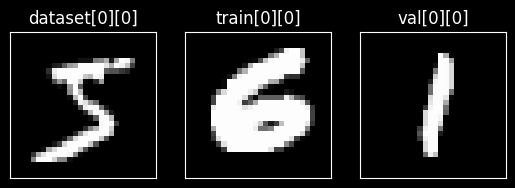

In [41]:
fig, axes = plt.subplots(1,3)

axes[0].imshow(dataset[0][0].reshape((28,28)), cmap="gray")
axes[0].set_title("dataset[0][0]")
axes[1].imshow(train[0][0].reshape((28,28)), cmap="gray")
axes[1].set_title("train[0][0]")
axes[2].imshow(val[0][0].reshape((28,28)), cmap="gray")
axes[2].set_title("val[0][0]")

for ax in axes:
  ax.set_xticks([])
  ax.set_yticks([])

Note that
- The data tensors' `requires_grad` equal `False`
- The (trainable) parameters' equal `True`

In [42]:
print(f'{dataset[0][0].requires_grad               = }')
print(f'{next(iter(train_loader))[1].requires_grad = }')
print(f'{next(model.parameters()).requires_grad    = }')

dataset[0][0].requires_grad               = False
next(iter(train_loader))[1].requires_grad = False
next(model.parameters()).requires_grad    = True


In [43]:
print(f'{next(iter(train_loader))[0].shape = }')
print(f'{next(iter(train_loader))[1].shape = }')

next(iter(train_loader))[0].shape = torch.Size([32, 1, 28, 28])
next(iter(train_loader))[1].shape = torch.Size([32])


## The Training Loop

In [44]:
import time
from sklearn.metrics import accuracy_score

In [45]:
num_epochs = 5
start = time.perf_counter()
for epoch in range(num_epochs):
    train_losses = []
    train_accuracies = []
    model.train()
    for batch in train_loader:
        # ipdb.set_trace()
        # pdb.set_trace()
        x_cpu, y_cpu = batch
        x_device = x_cpu.to(device)
        y_device = y_cpu.to(device)
        bs = x_device.shape[0]

        # 1. Forward
        # x_cpu.shape equals (bs, 1, 28, 28) but the model needs (bs, 28*28)
        logits = model(x_device.view(bs, -1))

        # 2. The objective function
        J = loss(logits, y_device)

        # 3. Clean the remains of the gradient
        for param in model.parameters():
            param.grad = None
        # Or alternatively. Cf.
        # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
        #model.zero_grad(set_to_none=True)
        # Or yet alternatively
        #optimiser.zero_grad(set_to_none=True)

        # 4. Accumulate the partial derivatives of J w.r.t. model.parameters()
        J.backward()
        # Or alternatively
        #params.grad.add_(dJ/dparams)

        # 5. Make a step
        optimiser.step()
        # Or alternatively
        #with torch.no_grad():
        #    params = params - eta * params.grad

        batch_loss = J.item()
        train_losses.append(batch_loss)

        # Calculate accuracy
        # Make sure all tensors here have requires_grad equal to False
        y_hat_device = torch.argmax(logits.detach(), dim=-1)
        # print(f'{y_hat_device.requires_grad = }')
        # Actually torch.argmax() seems to always return a torch.Tensor
        # whose requires_grad equal to False, i.e. detach() extraneous
        # pdb.set_trace()
        y_true = y_cpu
        y_pred = y_hat_device.to("cpu")
        # print(f'{y_pred.requires_grad = }')
        #batch_acc = accuracy_score(y_true, y_pred)
        # Or alternatively
        batch_acc = y_true.eq(y_pred).float().mean().item()
        train_accuracies.append(batch_acc)

    val_losses = []
    val_accuracies = []
    model.eval()
    for batch in val_loader:
        x_cpu, y_cpu = batch
        x_device = x_cpu.to(device)
        y_device = y_cpu.to(device)
        bs = x_device.shape[0]

        with torch.no_grad():
            logits = model(x_device.view(bs, -1))
            J = loss(logits, y_device)

        batch_loss = J.item()
        val_losses.append(batch_loss)

        y_hat_device = torch.argmax(logits.detach(), dim=-1)
        y_true = y_cpu
        y_pred = y_hat_device.to("cpu")
        batch_acc = accuracy_score(y_true, y_pred)
        val_accuracies.append(batch_acc)

    print(f'(epoch {epoch+1}) train loss = {sum(train_losses)/len(train_losses):.4f} '
          f'train acc = {sum(train_accuracies)/len(train_accuracies):.2f}\n'
          f'          val loss   = {sum(val_losses)/len(val_losses):.4f} '
          f'val acc   = {sum(val_accuracies)/len(val_accuracies):.2f}'
    )

end = time.perf_counter()
print(f'Took {end-start:.2f} sec to run {num_epochs} epochs')

(epoch 1) train loss = 0.8394 train acc = 0.78
          val loss   = 0.3924 val acc   = 0.89
(epoch 2) train loss = 0.3705 train acc = 0.89
          val loss   = 0.3150 val acc   = 0.91
(epoch 3) train loss = 0.3075 train acc = 0.91
          val loss   = 0.2750 val acc   = 0.92
(epoch 4) train loss = 0.2695 train acc = 0.92
          val loss   = 0.2457 val acc   = 0.93
(epoch 5) train loss = 0.2384 train acc = 0.93
          val loss   = 0.2203 val acc   = 0.93
Took 64.19 sec to run 5 epochs


## Q&A
1. Can `DataLoader` be told where to put the data? (I.e. `device` as an input arg)
    - Yes, but it seems that this is discouraged; rather, `pin_memory=True` is encouraged for CPU-to-CUDA data copying.
2. Training `model = instantiate_our_simple_model()`
   (i.e. with the default `num_intermediat_neurons=64`)
   on CPU and on T4 doesn't seem to give much efficiency diff. Where is the problem? Besides,
   when debugging for this, why raising `batch_size`
   doesn't make GPU/CPU RAM usage increase significantly?
    - Too small a NN model. Try with, say, `model = instantiate_our_simple_model(num_intermediate_neurons=5_000)` and you'll see the diff btw CPU and GPU efficiencies.
    - RAM usage is insignificant even when we raise
      `batch_size` to, say, `8192`. This is due to
      the fact that the MNIST image is small. Indeed,
      with the shape of `(1, 28, 28)`, a `float32` MNIST image is `28 * 28 * 4` Bytes, which is less than `4` KB. A batch of `8192` such images
      occupies **only about `32` MB of RAM**.
    - The following code cells are borrowed from
      [CUDA.jl](https://cuda.juliagpu.org/stable/tutorials/introduction/)
      and could help us confirm that GPU is working
      properly (provided that we choose T4/V100/A100 GPU for the runtime).

In [ ]:
N = 2**20
a_cpu = torch.full((N,), fill_value=1.0, dtype=torch.float32, device="cpu")
b_cpu = torch.full((N,), fill_value=2.0, dtype=torch.float32, device="cpu")
a_cuda = torch.full((N,), fill_value=1.0, dtype=torch.float32, device="cuda")
b_cuda = torch.full((N,), fill_value=2.0, dtype=torch.float32, device="cuda")

In [ ]:
%timeit a_cpu + b_cpu

In [ ]:
%timeit a_cuda + b_cuda

3. Why did Alfredo emphasize on that `J.backward()` **accumulates**, instead of computes, the gradient?
    - Note that, even before we are able to answer this, we could try to disable/comment **Step 3** in the training code while leaving the other steps unchanged
    ```python
    #for param in model.parameters():
    #    param.grad = None
    ```
    And the training/validation metrics will soon
    make us realize that this step is **indispensible**.

4. Note that in this particular MNIST example, `batch_size = 32` is a lot better than a super big `batch_size = 8192`, which is the diff btw mini-batch and batch training.
5. `ResNet` **converges faster** than the simpler model because residual mechanism kind of resolves the problem of vanishing gradient by making the route to the lower layers shallower/shorter.
6. We could predict the loss at the beginning of our training to be $(\ln 10)$

In [26]:
torch.log(torch.Tensor([10]))

tensor([2.3026])